In [1]:
from geopy.geocoders import Nominatim
import pandas as pd
import folium
from matplotlib import pyplot as plt

In [2]:
address = 'Warszawa, Polska'
contour = 'https://raw.githubusercontent.com/andilabs/warszawa-dzielnice-geojson/master/warszawa-dzielnice.geojson'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

52.2337172 21.07141112883227


In [3]:
warsaw_map = folium.Map(
    location=[latitude, longitude],
    zoom_start=10
)

folium.GeoJson(
    contour,
    name='geojson'
).add_to(warsaw_map)
warsaw_map

In [4]:
import requests
results = requests.get(contour).json()
borough = []
lat = []
long = []

for feature in results['features']:
    if feature['properties']['name'] == 'Warszawa':
        continue
    b_curr = feature['properties']['name']
    borough.append(b_curr)
    
    location = geolocator.geocode('Poland, Warsaw, {}'.format(b_curr))
    lat.append(location.latitude)
    long.append(location.longitude)

    
warsaw = pd.DataFrame(
    {
        'Latitude': lat,
        'Longitude': long
    }, index = borough)
warsaw.head()

,Latitude,Longitude
Ochota,52.212225,20.972630
Rembertów,52.261415,21.162819
Bemowo,52.238974,20.913288
Białołęka,52.319665,21.021177
Wesoła,52.251794,21.229276


In [5]:
CLIENT_ID = 'OCPQ2CI3R10LASMK1ZZRHHWIZCOPHCQ2XXWC4DPU00IFVAIC'
CLIENT_SECRET = '3QKJC2FKYUIGQO1Y5LCCAHF3NMBTYHUCEC2SAF5WH4DCP1FI'
VERSION = '20180605'


In [6]:
radius = 500
LIMIT = 100

rest = pd.DataFrame()

for bor in warsaw.index:
    lat = warsaw.loc[bor, 'Latitude']
    long = warsaw.loc[bor, 'Longitude']

    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        long, 
        radius, 
        LIMIT)
    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    nearby_venues = pd.io.json.json_normalize(venues)
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    try:
        nearby_venues =nearby_venues.loc[:, filtered_columns]
    except:
        continue
    nearby_venues['categories'] = nearby_venues['venue.categories'].apply(lambda x: x[0]['name'])
    nearby_venues = nearby_venues.drop('venue.categories', axis=1)
    nearby_venues = nearby_venues[nearby_venues['categories'].str.contains("Restaurant")]
    nearby_venues['Neighbourhood']=bor
    rest = rest.append(nearby_venues)



In [7]:
warsaw_rest = rest.reset_index().drop('index', axis=1)
warsaw_rest = warsaw_rest.rename(columns={'venue.name':'Venue',
                            'venue.location.lat': 'Latitude',
                            'venue.location.lng': 'Longitude',
                           'categories': 'Category'})
warsaw_rest.head(10)

,Venue,Latitude,Longitude,Category,Neighbourhood
0,A Modo Mio,52.208831,20.974334,Italian Restaurant,Ochota
1,Sedo Kebab,52.213745,20.978785,Turkish Restaurant,Ochota
2,Van Binh,52.210750,20.975944,Vietnamese Restaurant,Ochota
3,Smak Tradycji,52.210847,20.972557,Restaurant,Ochota
4,La Fiaccola,52.240811,20.912208,Italian Restaurant,Bemowo
5,Thai Me Up!,52.233707,21.020641,Thai Restaurant,Śródmieście
6,Bar Cô Tú,52.233142,21.020421,Asian Restaurant,Śródmieście
7,Supperlardo,52.232523,21.016744,Polish Restaurant,Śródmieście
8,Zapiecek,52.231529,21.019705,Polish Restaurant,Śródmieście
9,Raj w Niebie,52.232394,21.018595,Hawaiian Restaurant,Śródmieście


In [8]:
warsaw_pop = warsaw_rest.groupby('Neighbourhood').count().sort_values(by='Venue', ascending=False)['Venue']
warsaw_pop = warsaw_pop.reset_index()
warsaw_pop

,Neighbourhood,Venue
0,Śródmieście,24
1,Żoliborz,6
2,Ochota,4
3,Bemowo,1
4,Ursus,1
5,Ursynów,1
6,Wawer,1
7,Wola,1


Text(0.5,1,'Top 5 Number of Resteurants per Neighbourhood')

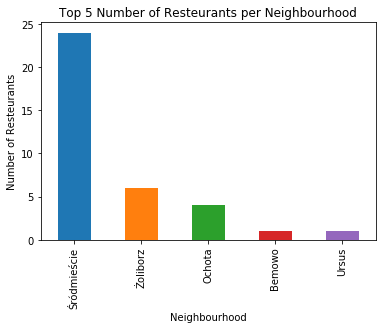

In [9]:
plt.figure();
warsaw_pop.set_index('Neighbourhood')['Venue'].head(5).plot.bar()
plt.xlabel('Neighbourhood')
plt.ylabel('Number of Resteurants')
plt.title('Top 5 Number of Resteurants per Neighbourhood')

In [13]:

warsaw_map = folium.Map(
    location=[latitude, longitude],
    zoom_start=10  # Limited levels of zoom for free Mapbox tiles.
)

#for index, row in warsaw_rest.iterrows():
#    folium.Marker(        
#        [row.Latitude, row.Longitude],
#        popup='Camp Muir'
#    ).add_to(warsaw_map)

folium.Choropleth(
    geo_data=contour,
    data=warsaw_pop,
    columns=['Neighbourhood', 'Venue'],
    key_on='feature.properties.name',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Resteurant Count (%)',
    reset=True
).add_to(warsaw_map)
warsaw_map

In [11]:
warsaw_type = warsaw_rest.groupby('Category').count().sort_values(by='Venue', ascending=False)['Venue']
warsaw_type

Category
Italian Restaurant               8
Vegetarian / Vegan Restaurant    4
Polish Restaurant                3
Asian Restaurant                 2
Mexican Restaurant               2
Thai Restaurant                  2
Sushi Restaurant                 2
Modern European Restaurant       2
Mediterranean Restaurant         2
Falafel Restaurant               2
Vietnamese Restaurant            2
Dim Sum Restaurant               1
Kebab Restaurant                 1
Indian Restaurant                1
Hawaiian Restaurant              1
Restaurant                       1
Fast Food Restaurant             1
Turkish Restaurant               1
Dumpling Restaurant              1
Name: Venue, dtype: int64

Text(0.5,1,'Top 5 Number of Resteurants by Type')

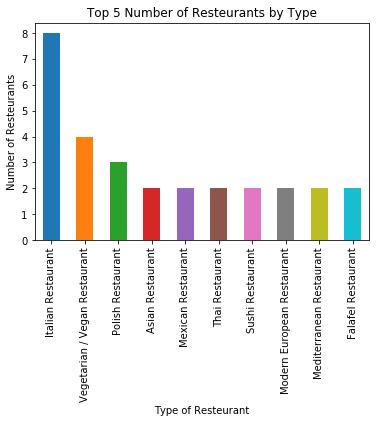

In [12]:
plt.figure()
warsaw_type.head(10).plot.bar()
plt.xlabel('Type of Resteurant')
plt.ylabel('Number of Resteurants')
plt.title('Top 5 Number of Resteurants by Type')
